#### Imports and Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Reading CSV from link
def read_csv_from_link(url):
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path,delimiter="\t",error_bad_lines=False, header=None)
    return df

In [3]:
# Loading All Data
# tamil_train = read_csv_from_link('https://drive.google.com/file/d/15auwrFAlq52JJ61u7eSfnhT9rZtI5sjk/view?usp=sharing')
# tamil_dev = read_csv_from_link('https://drive.google.com/file/d/1Jme-Oftjm7OgfMNLKQs1mO_cnsQmznRI/view?usp=sharing')
malayalam_train = read_csv_from_link('https://drive.google.com/file/d/13JCCr-IjZK7uhbLXeufptr_AxvsKinVl/view?usp=sharing')
malayalam_dev = read_csv_from_link('https://drive.google.com/file/d/1J0msLpLoM6gmXkjC6DFeQ8CG_rrLvjnM/view?usp=sharing')
# kannada_train = read_csv_from_link('https://drive.google.com/file/d/1BFYF05rx-DK9Eb5hgoIgd6EcB8zOI-zu/view?usp=sharing')
# kannada_dev = read_csv_from_link('https://drive.google.com/file/d/1V077dMQvscqpUmcWTcFHqRa_vTy-bQ4H/view?usp=sharing')

In [4]:
# Mal Preprocess
malayalam_train = malayalam_train.iloc[:, 0:2]
malayalam_train = malayalam_train.rename(columns={0: "text", 1: "label"})
# Stats
malayalam_train['label'] = pd.Categorical(malayalam_train.label)
# Mal Preprocess
malayalam_dev = malayalam_dev.iloc[:, 0:2]
malayalam_dev = malayalam_dev.rename(columns={0: "text", 1: "label"})
# Stats
malayalam_dev['label'] = pd.Categorical(malayalam_dev.label)

### Load Model

In [5]:
import torch

In [6]:
print("GPU Nos: {}".format(torch.cuda.device_count()))
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_name(1))

# Change Device - CPU/GPU-0/GPU-1
torch.cuda.set_device(1)
device = 'cuda'
device = device if torch.cuda.is_available() else 'cpu'

GPU Nos: 2
Tesla P100-PCIE-12GB
Tesla P100-PCIE-16GB


## Enter Path of Saved model here in torch.load()

In [7]:
# Model Select
import os
from os import listdir
from os.path import isfile, join
f = [x for x in listdir('../../finetuned_models/') if 'alayalam' in x and 'offensiv' not in x and 'collated' not in x and 'fusion' not in x]
f

['XLMroberta_custom_pretrained_Malayalam.pth',
 'Distilbert_m_base_cased_Malayalam_weighted.pth',
 'Indic_bert_Malayalam_weighted.pth',
 'XLMroberta_base_Malayalam_weighted.pth',
 'Distilbert_m_base_cased_Malayalam.pth',
 'XLMroberta_custom_pretrained_Malayalam_weighted.pth',
 'MURIL_cased_temp_Malayalam.pth',
 'XLMroberta_large_Malayalam_weighted.pth',
 'Mbert_base_cased_Malayalam.pth',
 'XLMroberta_base_Malayalam.pth',
 'Mbert_base_cased_Malayalam_weighted.pth',
 'XLMroberta_large_Malayalam.pth',
 'Indic_bert_Malayalam.pth',
 'MURIL_cased_temp_Malayalam_weighted.pth']

In [8]:
len(f)

14

### ALL models that we are ensembling

In [9]:
saved_model_filenames = [
 'XLMroberta_custom_pretrained_Malayalam.pth',
 'Distilbert_m_base_cased_Malayalam_weighted.pth',
 'Indic_bert_Malayalam_weighted.pth',
 'Distilbert_m_base_cased_Malayalam.pth',
 'XLMroberta_custom_pretrained_Malayalam_weighted.pth',
 'MURIL_cased_temp_Malayalam.pth',
 'XLMroberta_large_Malayalam_weighted.pth',
 'Mbert_base_cased_Malayalam.pth',
 'Mbert_base_cased_Malayalam_weighted.pth',
 'XLMroberta_large_Malayalam.pth',
 'Indic_bert_Malayalam.pth',
 'MURIL_cased_temp_Malayalam_weighted.pth',
    'XLMroberta_base_Malayalam_weighted.pth',
    'XLMroberta_base_Malayalam.pth',
]

In [10]:
model_pretrained_keys = [
    'xlm-roberta-base',
    'distilbert-base-multilingual-cased',
    'ai4bharat/indic-bert',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base',
    "simran-kh/muril-cased-temp",
    'xlm-roberta-large',
    'bert-base-multilingual-cased',
    'bert-base-multilingual-cased',
    'xlm-roberta-large',
    'ai4bharat/indic-bert',
    "simran-kh/muril-cased-temp",
    'xlm-roberta-base',
    'xlm-roberta-base',
]

### Get predictions

In [14]:
# Loading Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification

for index in range(len(model_pretrained_keys)):
    model_name = saved_model_filenames[index]
    pretrained_key = model_pretrained_keys[index]

    if pretrained_key == 'distilbert-base-multilingual-cased':
        tokenizer = BertTokenizer.from_pretrained(pretrained_key)
        model = BertForSequenceClassification.from_pretrained(pretrained_key, num_labels=5)
    else:
        tokenizer = AutoTokenizer.from_pretrained(pretrained_key)
        model = AutoModelForSequenceClassification.from_pretrained(pretrained_key, num_labels=5)

    state_dict = torch.load(os.path.join('../../finetuned_models/', model_name))
    model.load_state_dict(state_dict)
    model.eval()

    label_mapping = {
        'Not_offensive': 0, 
        'not-malayalam': 1, 
        'Offensive_Targeted_Insult_Group': 2, 
        'Offensive_Untargetede': 3, 
        'Offensive_Targeted_Insult_Individual': 4
    }
    
    # Collecting Text and Labels
    train_batch_sentences = list(malayalam_train['text'])
    train_batch_labels =  [label_mapping[x] for x in malayalam_train['label']]
    dev_batch_sentences = list(malayalam_dev['text'])
    dev_batch_labels =  [label_mapping[x] for x in malayalam_dev['label']]

    # Convert to Tensor
    train_encodings = tokenizer(train_batch_sentences, padding='max_length', truncation=True, max_length=64, return_tensors="pt")
    train_labels = torch.tensor(train_batch_labels)
    dev_encodings = tokenizer(dev_batch_sentences, padding='max_length', truncation=True, max_length=64, return_tensors="pt")
    dev_labels = torch.tensor(dev_batch_labels)

    # Dataset
    from torch.utils.data import Dataset

    class Malayalam_Offensive_Dataset(Dataset):
        def __init__(self, encodings, labels, bpe = False):
            self.encodings = encodings
            self.labels = labels
            self.is_bpe_tokenized = bpe

        def __getitem__(self, idx):
            if not self.is_bpe_tokenized:
                item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            else:
                item = {
                    'input_ids': torch.LongTensor(self.encodings[idx].ids),
                    'attention_mask': torch.LongTensor(self.encodings[idx].attention_mask)
                }
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)
    
    # Defining Datasets
    train_dataset = Malayalam_Offensive_Dataset(train_encodings, train_labels, bpe = False)
    dev_dataset = Malayalam_Offensive_Dataset(dev_encodings, dev_labels, bpe = False)

    ### Run Models-1
    from torch.utils.data import DataLoader
    from tqdm.notebook import tqdm
    from sklearn.metrics import classification_report, f1_score

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Dataloaders
    dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

    dev_preds_ = []
    with torch.set_grad_enabled(False):
        for batch in tqdm(dev_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            for logits in outputs[1].cpu().numpy():
                dev_preds_.append(np.exp(logits)/np.sum(np.exp(logits)))

    np.save('../../model_prediction_probs/preds_'+modelname+'.npy', dev_preds_)
    del model
    torch.cuda.empty_cache()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

/home/punyajoy/.conda/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/punyajoy/.conda/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transform

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.weight', 'sop_classifier.classifier.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indi

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transform

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Some weights of the model checkpoint at simran-kh/muril-cased-temp were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not

KeyboardInterrupt: 

#### Load preds

In [15]:
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score

label_mapping = {
    'Not_offensive': 0, 
    'not-malayalam': 1, 
    'Offensive_Targeted_Insult_Group': 2, 
    'Offensive_Untargetede': 3, 
    'Offensive_Targeted_Insult_Individual': 4
}

# Collecting Text and Labels
train_batch_sentences = list(malayalam_train['text'])
train_batch_labels =  [label_mapping[x] for x in malayalam_train['label']]
dev_batch_sentences = list(malayalam_dev['text'])
dev_batch_labels =  [label_mapping[x] for x in malayalam_dev['label']]

In [16]:
model_pretrained_keys = [
    'xlm-roberta-base',
    'distilbert-base-multilingual-cased',
    'ai4bharat/indic-bert',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base',
    "simran-kh/muril-cased-temp",
    'xlm-roberta-large',
    'bert-base-multilingual-cased',
    'bert-base-multilingual-cased',
    'xlm-roberta-large',
    'ai4bharat/indic-bert',
    "simran-kh/muril-cased-temp",
    'xlm-roberta-base',
    'xlm-roberta-base',
]

In [17]:
load_model_filenames = [
    'XLMroberta_custom_pretrained_Malayalam.pth',
    'Distilbert_m_base_cased_Malayalam_weighted.pth',
    'Indic_bert_Malayalam_weighted.pth',
    'Distilbert_m_base_cased_Malayalam.pth',
    'XLMroberta_custom_pretrained_Malayalam_weighted.pth',
    'MURIL_cased_temp_Malayalam.pth',
    'XLMroberta_large_Malayalam_weighted.pth',
    'Mbert_base_cased_Malayalam.pth',
    'Mbert_base_cased_Malayalam_weighted.pth',
    'XLMroberta_large_Malayalam.pth',
    'Indic_bert_Malayalam.pth',
    'MURIL_cased_temp_Malayalam_weighted.pth',
    'XLMroberta_base_Malayalam_weighted.pth',
    'XLMroberta_base_Malayalam.pth',
]

all_dev_preds = []
for modelname in load_model_filenames:
    all_dev_preds.append(np.load('../../model_prediction_probs/preds_'+modelname+'.npy'))

In [18]:
print(len(load_model_filenames))

14


In [19]:
for dev_preds, mn in zip(all_dev_preds, load_model_filenames):
    final_dev_preds = np.argmax(dev_preds, axis = 1)
    y_true = dev_batch_labels
    y_pred = final_dev_preds
    target_names = label_mapping.keys()
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(mn)
    print(report)

XLMroberta_custom_pretrained_Malayalam.pth
                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.99      0.99      1779
                       not-malayalam       0.89      0.93      0.91       163
     Offensive_Targeted_Insult_Group       0.82      0.69      0.75        13
               Offensive_Untargetede       0.74      0.70      0.72        20
Offensive_Targeted_Insult_Individual       0.93      0.58      0.72        24

                            accuracy                           0.97      1999
                           macro avg       0.87      0.78      0.82      1999
                        weighted avg       0.97      0.97      0.97      1999

Distilbert_m_base_cased_Malayalam_weighted.pth
                                      precision    recall  f1-score   support

                       Not_offensive       0.97      0.96      0.97      1779
                       not-malayalam       0.79 

### Averaging Ensemble

In [20]:
all_dev_preds = np.array(all_dev_preds)

# Initialise Weights
w = np.ones(all_dev_preds.shape[0])
softmax_w = np.exp(w)/np.sum(np.exp(w))

weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

In [21]:
y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)

In [13]:
print(report)

                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.99      0.98      1779
                       not-malayalam       0.90      0.93      0.91       163
     Offensive_Targeted_Insult_Group       0.82      0.69      0.75        13
               Offensive_Untargetede       0.93      0.65      0.76        20
Offensive_Targeted_Insult_Individual       0.92      0.50      0.65        24

                            accuracy                           0.97      1999
                           macro avg       0.91      0.75      0.81      1999
                        weighted avg       0.97      0.97      0.97      1999



### Optimising with GA

 The best solution found:                                                                           
 [4.98740038 1.35822305 2.14807284 2.79479706 4.20657479 0.68412483
 3.8948384  0.44254299 0.4904552  1.49206806 1.38916164 2.81783021
 1.80244462 4.71719699]

 Objective function:
 0.1496408463459632


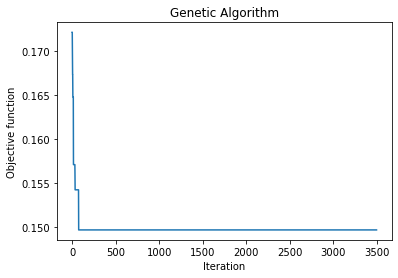

In [18]:
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    softmax_w = np.exp(X)/np.sum(np.exp(X))
    weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
    weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
    final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

    y_true = dev_batch_labels
    y_pred = final_dev_preds
    score = f1_score(y_true, y_pred, average='macro')
    return 1-score

varbound=np.array([[0, 5]]*all_dev_preds.shape[0])

model=ga(function=f,dimension=all_dev_preds.shape[0],variable_type='real',variable_boundaries=varbound)

model.run()

In [24]:
convergence=model.report
solution=model.output_dict

In [25]:
solution

{'variable': array([4.98740038, 1.35822305, 2.14807284, 2.79479706, 4.20657479,
        0.68412483, 3.8948384 , 0.44254299, 0.4904552 , 1.49206806,
        1.38916164, 2.81783021, 1.80244462, 4.71719699]),
 'function': 0.1496408463459632}

In [ ]:
X = solution['variable']

In [14]:
import pickle
saved_model_filename = 'GA_v1_malayalam'

with open("../../dev_preds/weights_" + saved_model_filename + ".pickle", 'rb') as handle:
    mw = pickle.load(handle)
    
X = [mw[index][0] for index in mw.keys()]

In [15]:
X

[4.987400383529981,
 1.358223048938526,
 2.1480728379176064,
 2.7947970649265406,
 4.206574786073908,
 0.6841248293693636,
 3.8948383954170698,
 0.44254299249817775,
 0.4904552048096972,
 1.4920680613973296,
 1.389161641030305,
 2.8178302110508153,
 1.8024446186776188,
 4.717196990349133]

In [16]:
softmax_w = np.exp(X)/np.sum(np.exp(X))
weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)

In [17]:
print(report)

                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.99      0.99      1779
                       not-malayalam       0.92      0.94      0.93       163
     Offensive_Targeted_Insult_Group       0.90      0.69      0.78        13
               Offensive_Untargetede       0.94      0.75      0.83        20
Offensive_Targeted_Insult_Individual       0.93      0.58      0.72        24

                            accuracy                           0.98      1999
                           macro avg       0.93      0.79      0.85      1999
                        weighted avg       0.98      0.98      0.98      1999



In [18]:
f1_score(y_true, y_pred, average='macro')

0.8503591536540368

### Save stuff

In [19]:
saved_model_filename = 'GA_v1_malayalam'
np.savetxt("../../dev_preds/" + saved_model_filename + ".csv", final_dev_preds, delimiter=",")

In [21]:
np.save("../../model_prediction_probs/"+saved_model_filename+".npy", weighted_dev_preds)

In [34]:
a = {x:(y,z) for x, y, z in zip(load_model_filenames, np.array(solution['variable']), model_pretrained_keys)}

In [35]:
import pickle
with open("../../dev_preds/weights_" + saved_model_filename + ".pickle", 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)